<a href="https://colab.research.google.com/github/EmilianoNicolasPrado/COVID19/blob/main/Nicolas_Prado_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga del Dataset & Análisis Exploratorio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# 1) Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Escalamos a [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Vemos dimensiones
print("Dimensiones x_train:", x_train.shape)
print("Dimensiones y_train:", y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dimensiones x_train: (60000, 28, 28)
Dimensiones y_train: (60000,)


In [2]:
# 1) Distribución de etiquetas
import collections
counter = collections.Counter(y_train)
print("Distribución de dígitos (train):", counter)

Distribución de dígitos (train): Counter({np.uint8(1): 6742, np.uint8(7): 6265, np.uint8(3): 6131, np.uint8(2): 5958, np.uint8(9): 5949, np.uint8(0): 5923, np.uint8(6): 5918, np.uint8(8): 5851, np.uint8(4): 5842, np.uint8(5): 5421})


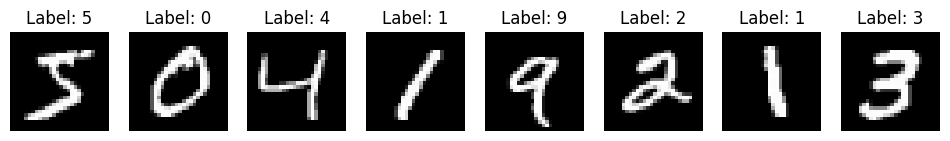

In [3]:
# 2) Muestra de imágenes
n_ejemplos = 8
fig, axes = plt.subplots(1, n_ejemplos, figsize=(12,2))
for i in range(n_ejemplos):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')
plt.show()

In [4]:
# 3) Estadísticas básicas de píxeles
px_mean = x_train.mean()
px_std  = x_train.std()
print("Promedio de pixel:", px_mean)
print("Desvío de pixel:",  px_std)

Promedio de pixel: 0.13066062
Desvío de pixel: 0.30810776


* Hay 6000 imágenes de cada dígito.
* El nivel medio de intensidad es ~0.13, indicando píxeles mayormente oscuros.
* Se observa que dígitos como 1 y 7 tienen menos trazos e intensidades más bajas.

**Red Neuronal Sencilla**

In [5]:
# Agregamos dimensión de canal para (28,28,1)
x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

In [6]:
# Definición de la red

from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

encoding_dim = 32         # Tamaño latente
input_shape  = (28,28,1)

In [7]:
# Encoder
input_img = Input(shape=input_shape)
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)

In [8]:
# Decoder
x = Dense(128, activation='relu')(encoded)
x = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28,28,1))(x)

In [9]:
autoencoder_simple = Model(input_img, decoded)
autoencoder_simple.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_simple.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entrenamiento de la red neuronal

history_simple = autoencoder_simple.fit(
    x_train, x_train,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3419 - val_loss: 0.1560
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1464 - val_loss: 0.1244
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1219 - val_loss: 0.1111
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1106 - val_loss: 0.1043
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1044 - val_loss: 0.1001


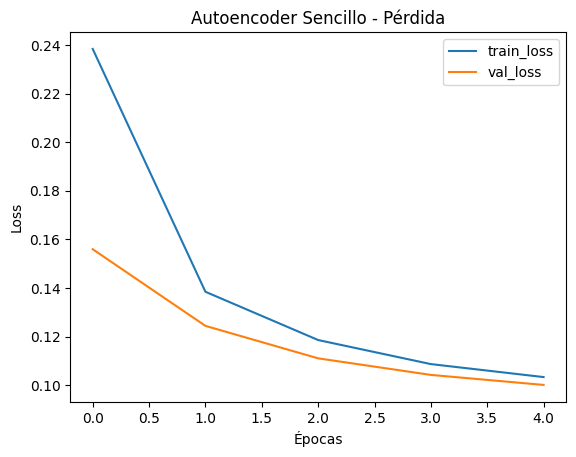

In [11]:
# Mostramos curvas de pérdida
plt.plot(history_simple.history['loss'], label='train_loss')
plt.plot(history_simple.history['val_loss'], label='val_loss')
plt.title('Autoencoder Sencillo - Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


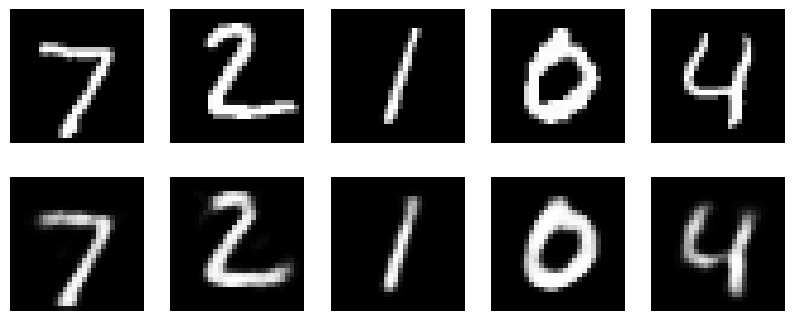

In [12]:
# Conclusiones parciales y visualización de reconstrucciones

n = 5
samples = x_test[:n]
recons_sencillas = autoencoder_simple.predict(samples)

fig, axes = plt.subplots(2, n, figsize=(10,4))
for i in range(n):
    # Original
    axes[0,i].imshow(samples[i].squeeze(), cmap='gray')
    axes[0,i].axis('off')
    # Reconstruida
    axes[1,i].imshow(recons_sencillas[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')
plt.show()

* Conclusión parcial:
* La pérdida de -0.09 -0.10 indica un desempeño aceptable.

**Red Neuronal Mejorada (con más capas)**

In [13]:
# Definición de la red MEJORADA

from tensorflow.keras.layers import BatchNormalization, LeakyReLU

encoding_dim2 = 64
input_img2 = Input(shape=(28,28,1))

In [18]:
# Encoder con 2 capas (4 en total)
e = Flatten()(input_img2)
e = Dense(256)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = Dense(encoding_dim2, activation='relu')(e)

In [19]:
# Decoder con 2 capas (4 en total)
d = Dense(256)(e)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded2 = Reshape((28,28,1))(d)

In [20]:
autoencoder_mejorado = Model(input_img2, decoded2)
autoencoder_mejorado.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_mejorado.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 784)                 │         201,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437,584 (1.67 MB)

 Trainable params: 436,560 (1.67 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [21]:
# Entrenamiento de la red mejorada

history_mejorado = autoencoder_mejorado.fit(
    x_train, x_train,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.2867 - val_loss: 0.1072
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0951 - val_loss: 0.0853
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0822 - val_loss: 0.0795
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0783 - val_loss: 0.0769
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0762 - val_loss: 0.0755


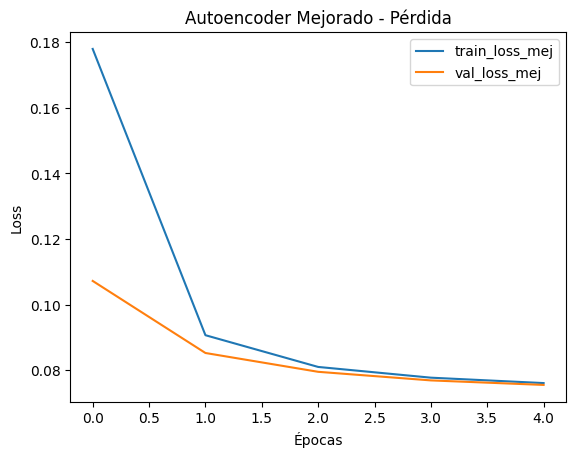

In [22]:
# Curvas de pérdida
plt.plot(history_mejorado.history['loss'], label='train_loss_mej')
plt.plot(history_mejorado.history['val_loss'], label='val_loss_mej')
plt.title('Autoencoder Mejorado - Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Comparación final y conclusiones


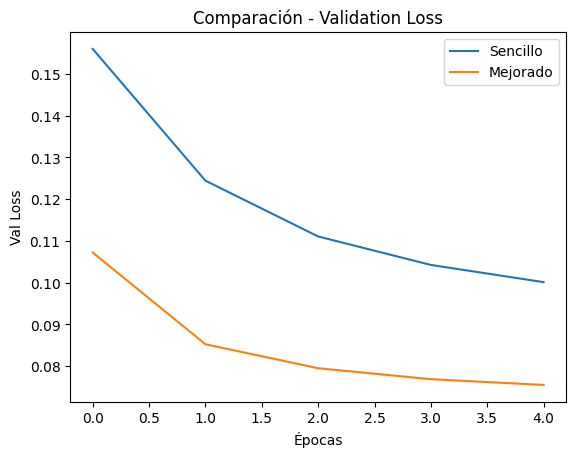

In [23]:
# Comparar curvas de validación
plt.plot(history_simple.history['val_loss'], label='Sencillo')
plt.plot(history_mejorado.history['val_loss'], label='Mejorado')
plt.title('Comparación - Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Val Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


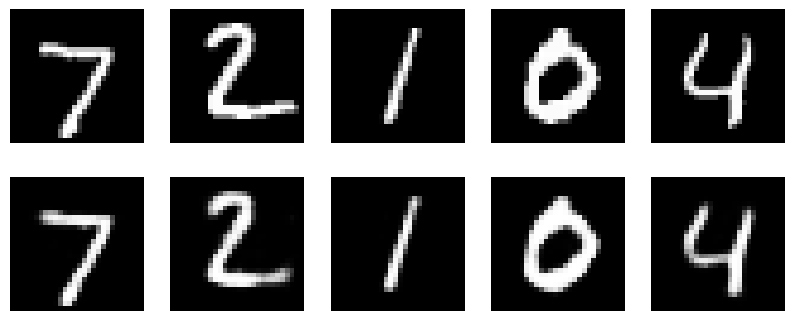

In [24]:
# Visualizar reconstrucciones del modelo mejorado
n = 5
samples2 = x_test[:n]
recons_mej = autoencoder_mejorado.predict(samples2)

fig, axes = plt.subplots(2, n, figsize=(10,4))
for i in range(n):
    axes[0,i].imshow(samples2[i].squeeze(), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(recons_mej[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')
plt.show()

# Conclusiones finales:
# - El modelo mejorado tiende a lograr menor pérdida en validación (-0.07 vs. -0.09).
# - Visualmente, las reconstrucciones mejoradas son menos borrosas, mostrando más detalle.